# Neurally Embedded Emojis
As I move through my 20's I'm consistently delighted by the subtle ways in which I've changed.

- Will at 22: Reggaetón is a miserable, criminal assault to my ears.
- Will at 28: [Despacito (Remix)](https://www.youtube.com/watch?v=72UO0v5ESUo) for breakfast, lunch and dinner.


- Will at 22: Western Europe is boring. No — I've seen a lot of it! Everything is too clean, too nice, too perfect for my taste.
- Will at 28, in Barcelona, after 9 months in [Casablanca](http://willwolf.io/2016/07/29/my-open-source-machine-learning-masters-in-casablanca-morocco/): Wait a second: *I get it now*. What *is* this tropical paradise of crosswalks, vehicle civility and apple-green parks and where has it been all my life?


- Will at 22: Emojis are weird.
- Will at 28: 🚀 🤘 💃🏿 🙃.

Emojis are an increasingly-pervasive sub-lingua-franca of the internet. They capture meaning in a rich, concise manner — alternative to the 13 seconds of mobile thumb-fumbling required to capture the same meaning with text. Furthermore, they bring two levels of semantic information: their placement in raw text and the pixels of the emoji itself.

## Question-answer models
The original aim of this post was to explore Siamese question-answer models of the type typically applied to the [InsuranceQA Corpus](https://github.com/shuzi/insuranceQA) as introduced in "Applying Deep Learning To Answer Selection: A Study And An Open Task" ([Feng, Xiang, Glass, Wang, & Zhou, 2015](https://arxiv.org/pdf/1508.01585v2.pdf)). We'll call them SQAM for clarity. The basic architecture looks as follows:

![qa model architecture](./figures/qa_model_architecture.png)

By layer and in general terms:

1. An input — typically a sequence of token ids — for both question (Q) and answer (A).
2. An embedding layer.
3. Convolutional layer(s), or any layers that extract features from the matrix of embeddings. A matrix, because the respective inputs are sequences of token ids; each id is embedded into its own vector.
4. A max-pooling layer.
5. A `tanh` non-linearity.
6. The cosine of the angle between the resulting, respective embeddings.

### As canonical recommendation
Question answering can be viewed as canonical recommendation: embed entities into Euclidean space in a meaningful way, then compute dot products between these entities and sort the list. In this vein, the above network is (thus far) quite similar to classic matrix factorization.

1. Instead of factorizing our matrix via [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) or [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares) we build a neural network that accepts `(question, answer)`, i.e. `(user, item)`, pairs and outputs their similarity. The second-to-last layer gives the respective embeddings. We train this network in a supervised fashion, optimizing its parameters via stochastic gradient descent.
2. Instead of jumping directly from input-index (or a sequence thereof) to embedding, we first compute convolutional features.

In contrast, the network above boasts one key difference: both question and answer, i.e. user and item, are transformed via the same set of (convolutional) parameters en route to embedding.

Furthermore, and not unique to SQAMs, our inputs are *any* two sequences of (tokenized, max-padded, etc.) text: we are not restricted to only those observed in the training set.

## Question-emoji models
Given my accelerating proclivity towards the internet's new alphabet, I decided to build text-question-emoji-answer models instead. In fact, this gives yet another avenue for prediction; if we make a model of the answers (emojis) themselves, we can now predict on, i.e. compute similarity with, each of

1. Emojis we saw in the training set.
2. New emojis, i.e. either not in the training set or new (like, released months from now) altogether.
3. Novel emojis *generated* from the model of our data. In this way, we could conceivably answer a question with: "we suggest this new emoji we've algorithmically generated ourselves that no one's ever seen before."

Let's get started.

## Convolutional variational autoencoders
Variational autoencoders are comprised of two models: an encoder and a decoder. The encoder embeds our 872 [emojis](https://github.com/twitter/twemoji) of size $(36, 36, 4)$ into a low-dimensional latent code, $z_e \in \mathbb{R}^{16}$, where $z_e$ is a sample from an emoji-specific Gaussian. The decoder takes as input $z_e$ and produces a reconstruction of the original emoji. As each individual $z_e$ is normally distributed, $z$ should be distributed normally as well. We can verify this with a quick simulation.

In [24]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('seaborn-whitegrid')

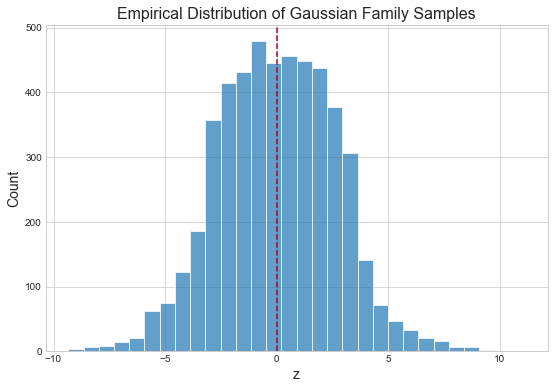

In [25]:
mu = np.linspace(-3, 3, 10)
sd = np.linspace(0, 3, 10)
z_samples = []

for m in mu:
    for s in sd:
        samples = np.random.normal(loc=m, scale=s, size=50)
        z_samples.append( samples )
        

z_samples = np.array(z_samples).ravel()

plt.figure(figsize=(9, 6))
plt.hist(z_samples, edgecolor='white', linewidth=1, bins=30, alpha=.7)
plt.axvline(0, color='#A60628', linestyle='--')
plt.xlabel('z', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Empirical Distribution of Gaussian Family Samples', fontsize=16)

Training a variational autoencoder to learn low-dimensional emoji embeddings serves two principal ends:

1. We can feed these low-dimensional embeddings as input to our SQAM.
2. We can generate novel emojis with which to answer questions.

As the embeddings in #1 are multivariate Gaussian, we can perform #2 by passing Gaussian samples into our decoder. We can do this by sampling evenly-spaced percentiles from the inverse CDF of the aggregate embedding distribution:

```python
percentiles = np.linspace(0, 1, 20)
for p in percentiles:
    z = norm.ppf(p, size=16)
    generated_emoji = decoder.predict([z])
```

NB: `norm.ppf` does *not* accept a `size` parameter; I believe sampling from the inverse CDF of a *multivariate* Gaussian is non-trivial in Python.

Similarly, we could simply iterate over `(mu, sd)` pairs outright:

```python
axis = np.linspace(-3, 3, 20)
for mu in axis:
    for sd in axis:
        z = norm.rvs(loc=mu, scale=sd, size=16)
        generated_emoji = decoder.predict([z])
```

The ability to generate new emojis via samples from a well-studied distribution, the Gaussian, is a key reason for choosing a variational autoencoder.

Finally, as we are working with images, I employ convolutional intermediary layers.

## Data preparation

In [26]:
import os
import random

from itertools import product

import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, dot, merge
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Lambda
from keras.layers import Bidirectional, Conv2D, Conv2DTranspose, LSTM, MaxPool1D
from keras.layers import Layer as KerasLayer, Reshape
from keras.losses import mean_squared_error, binary_crossentropy, mean_absolute_error
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
from matplotlib import gridspec
import numpy as np
import pandas as pd
import PIL
from scipy.ndimage import imread
from sklearn.preprocessing import scale
import tensorflow as tf

Using TensorFlow backend.


In [276]:
EMOJIS_DIR = 'data/emojis'
N_CHANNELS = 4
EMOJI_SHAPE = (36, 36, N_CHANNELS)


emojis_dict = {}

for slug in os.listdir(EMOJIS_DIR):
    path = os.path.join(EMOJIS_DIR, slug)
    emoji = imread(path)
    if emoji.shape == (36, 36, 4):
        emojis_dict[slug] = emoji

emojis = np.array( list(emojis_dict.values()) )

### Split data into train, validation sets 
Additionally, scale pixel values to $[0, 1]$.

In [277]:
train_mask = np.random.rand( len(emojis) ) < 0.8

X_train = y_train = emojis[train_mask] / 255.
X_val = y_val = emojis[~train_mask] / 255.

print('Dataset sizes:')
print(f'    X_train:  {X_train.shape}')
print(f'    X_val:    {X_val.shape}')
print(f'    y_train:  {y_train.shape}')
print(f'    y_val:    {y_val.shape}')

Dataset sizes:
    X_train:  (685, 36, 36, 4)
    X_val:    (182, 36, 36, 4)
    y_train:  (685, 36, 36, 4)
    y_val:    (182, 36, 36, 4)


Before we begin, let's examine some emojis.

In [278]:
def display_emoji(emoji_arr):
    return PIL.Image.fromarray(emoji_arr)

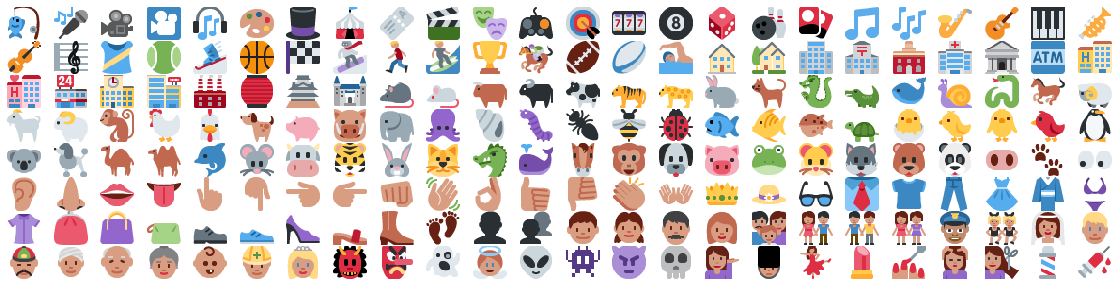

In [279]:
n_rows = 8
n_cols = 24

plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.025, hspace=.025)

for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(emojis[i + 200], cmap='gray', interpolation='nearest')

plt.savefig('figures/emojis.png', bbox_inches='tight')

## Model emojis

In [280]:
EMBEDDING_SIZE = 16
FILTER_SIZE = 64
BATCH_SIZE = 16
WEIGHTS_PATH = 'weights/epoch_{epoch:02d}-loss_{val_loss:.2f}.hdf5'

### Variational layer

This is taken from a previous post of mine, [Transfer Learning for Flight Delay Prediction via Variational Autoencoders](http://willwolf.io/2017/05/08/transfer-learning-flight-delay-prediction/).

In [281]:
class VariationalLayer(KerasLayer):

    def __init__(self, embedding_dim: int, epsilon_std=1.):
        '''A custom "variational" Keras layer that completes the
        variational autoencoder.

        Args:
            embedding_dim : The desired number of latent dimensions in our
                embedding space.
        '''
        self.embedding_dim = embedding_dim
        self.epsilon_std = epsilon_std
        super().__init__()

    def build(self, input_shape):
        self.z_mean_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_mean_weights'
        )
        self.z_mean_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_mean_bias'
        )
        self.z_log_var_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_log_var_weights'
        )
        self.z_log_var_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_log_var_bias'
        )
        super().build(input_shape)

    def call(self, x):
        z_mean = K.dot(x, self.z_mean_weights) + self.z_mean_bias
        z_log_var = K.dot(x, self.z_log_var_weights) + self.z_log_var_bias
        epsilon = K.random_normal(
            shape=K.shape(z_log_var),
            mean=0.,
            stddev=self.epsilon_std
        )

        kl_loss_numerator = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        self.kl_loss = -0.5 * K.sum(kl_loss_numerator, axis=-1)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def loss(self, x, x_decoded):
        base_loss = binary_crossentropy(x, x_decoded)
        base_loss = tf.reduce_sum(base_loss, axis=[-1, -2])
        return base_loss + self.kl_loss

    def compute_output_shape(self, input_shape):
        return input_shape[:1] + (self.embedding_dim,)

### Autoencoder

In [282]:
# encoder
original = Input(shape=EMOJI_SHAPE, name='original')

conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, input_shape=original.shape, padding='same', activation='relu')(original)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(conv)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(conv)

flat = Flatten()(conv)
variational_layer = VariationalLayer(EMBEDDING_SIZE)
variational_params = variational_layer(flat)

encoder = Model([original], [variational_params], name='encoder')

# decoder
encoded = Input(shape=(EMBEDDING_SIZE,))

upsample = Dense(np.multiply.reduce(EMOJI_SHAPE), activation='relu')(encoded)
reshape = Reshape(EMOJI_SHAPE)(upsample)

deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu', input_shape=encoded.shape)(reshape)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
dropout = Dropout(.8)(deconv)
reconstructed = Conv2DTranspose(filters=N_CHANNELS, kernel_size=3, padding='same', activation='sigmoid')(dropout)

decoder = Model([encoded], [reconstructed], name='decoder')

# end-to-end
encoder_decoder = Model([original], decoder(encoder([original])))

The full model `encoder_decoder` is composed of separate models `encoder` and `decoder`. Training the former will implicitly train the latter two; they are available for our use thereafter.

The above architecture takes inspiration from [Keras](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py), [Edward](https://github.com/blei-lab/edward/blob/master/examples/vae_convolutional.py) and the GDGS (gradient descent by grad student) method by as discussed by [Brudaks on Reddit](https://www.reddit.com/r/MachineLearning/comments/6hso7g/d_how_do_people_come_up_with_all_these_crazy_deep/):

> A popular method for designing deep learning architectures is GDGS (gradient descent by grad student).
This is an iterative approach, where you start with a straightforward baseline architecture (or possibly an earlier SOTA), measure its effectiveness; apply various modifications (e.g. add a highway connection here or there), see what works and what does not (i.e. where the gradient is pointing) and iterate further on from there in that direction until you reach a (local?) optimum.

I'm not a grad student, but I think it still plays.

### Fit model

In [283]:
encoder_decoder.compile(optimizer=Adam(.003), loss=variational_layer.loss)
encoder_decoder.load_weights('weights/backup_reasonable_weights.h5')

checkpoint_callback = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

# encoder_decoder_fit = encoder_decoder.fit(
#     x=X_train,
#     y=y_train,
#     batch_size=16,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[checkpoint_callback]
# )

## Generate emojis
As promised, let's generate emojis. Again, latent codes are distributed as a (16-dimensional) Gaussian; to generate, we'll simply need to take samples thereof and feed them to our `decoder`.

While scanning a 16-dimensional hypercube, i.e. taking (evenly-spaced) samples from our latent space, is a few lines of Numpy, visualizing a 16-dimensional grid is impractical. In solution, we'll work on a 2-dimensional grid while treating subsets of our latent space as homogenous.

For example, if our 2-D sample were `(0, 1)`, we could posit 16-D samples as:

    A. `(0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1)`
    B. `(0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1)`
    C. `(0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1)`

Then, if another sample were `(2, 3.5)`, we could posit 16-D samples as:

    A. `(2, 2, 2, 2, 2, 2, 2, 2, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5)`
    B. `(2, 3.5, 2, 3.5, 2, 3.5, 2, 3.5, 2, 3.5, 2, 3.5, 2, 3.5, 2, 3.5)`
    C. `(2, 2, 3.5, 3.5, 2, 2, 3.5, 3.5, 2, 2, 3.5, 3.5, 2, 2, 3.5, 3.5)`

There is no math here: I'm just creating 16-element lists in different ways. We'll then plot "A-lists," "B-lists," etc. separately.

In [284]:
def compose_code_A(coord_1, coord_2):
    return 8 * [coord_1] + 8 * [coord_2]


def compose_code_B(coord_1, coord_2):
    return 8 * [coord_1, coord_2]


def compose_code_C(coord_1, coord_2):
    return 4 * [coord_1, coord_1, coord_2, coord_2]


ticks = 20
axis = np.linspace(-2, 2, ticks)


def plot_generated_emojis(compose_code_func, decoder=decoder, ticks=ticks, axis=axis):
    # generate latent codes
    linspace_codes = [compose_code_func(i, j) for i, j in product(axis, axis)]
    
    # generate emojis
    generated_emojis = decoder.predict(linspace_codes)
    
    # plot
    n_rows = n_cols = ticks

    plt.figure(figsize=(12, 9))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=.01, hspace=0)

    for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
        ax = plt.subplot(gs[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        ax.imshow(generated_emojis[i])

    plt.suptitle('Generated Emojis')

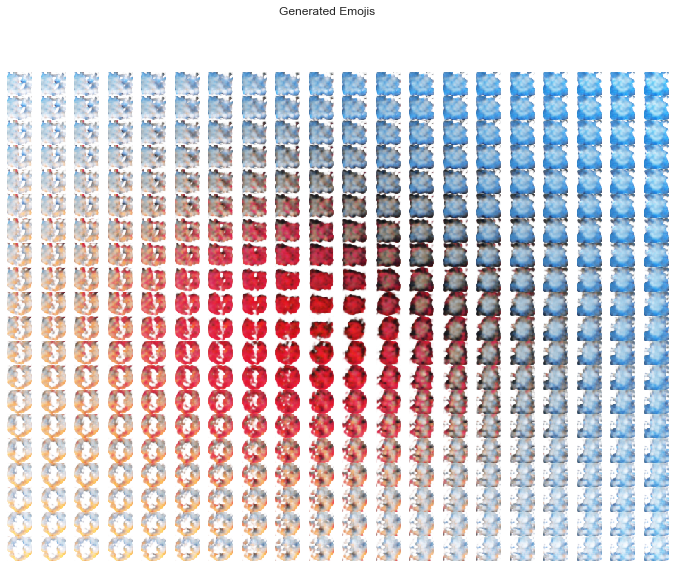

In [146]:
plot_generated_emojis(compose_code_A)
plt.savefig('figures/generated_emojis_A.png', bbox_inches='tight')

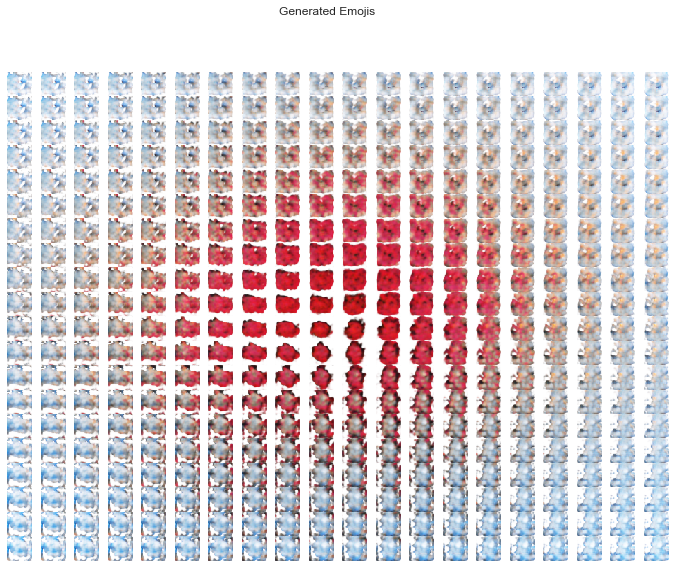

In [147]:
plot_generated_emojis(compose_code_B)
plt.savefig('figures/generated_emojis_B.png', bbox_inches='tight')

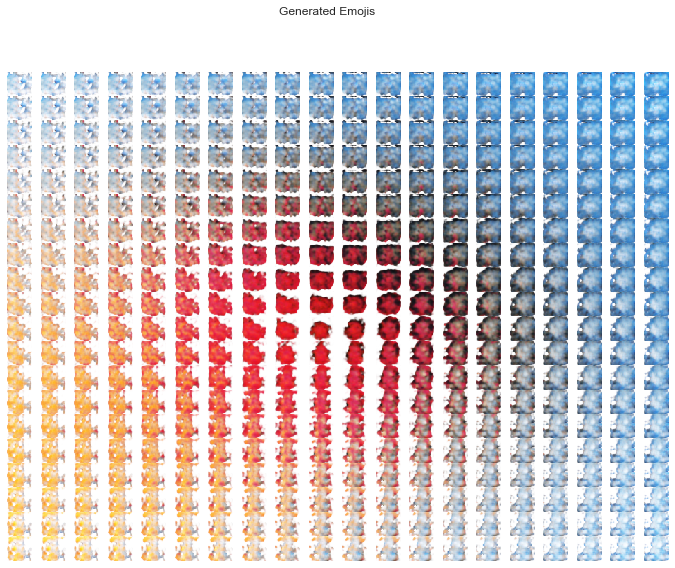

In [148]:
plot_generated_emojis(compose_code_C)
plt.savefig('figures/generated_emojis_C.png', bbox_inches='tight')

As our emojis live in a continuous latent space we can can observe the smoothness of the transition from one to the next.

The generated emojis have the makings of maybe some devils, maybe some bubbles, maybe some hearts, maybe some fish. I doubt they'll be featured in a tweet-near-you anytime soon.

## Text-question, emoji-answer
I spent a while looking for an adequate dataset to no avail. (Most Twitter datasets are not open-source, I requested my own tweets days ago and continue to wait, etc.) As such, I'm working with the [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment): tweets are labeled as `positive`, `neutral`, `negative` which I've mapped to 🎉, 😈 and 😡.

### Constrastive loss
We've thus far discussed the SQAM. Our final model will make use of two SQAM's in parallel, as follows:

1. Receive `(question, correct_answer, incorrect_answer)` triplets as input.
2. Compute the cosine similarity between `question`, `correct_answer` via `SQAM_1` — `correct_cos_sim`.
3. Compute the cosine similarity between `question`, `incorrect_answer` via `SQAM_2` — `incorrect_cos_sim`.

The model is trained to minimize the following: `max(0, margin - correct_cos_sim + incorrect_cos_sim)`, a variant of the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss). This ensures that `(question, correct_answer)` pairs have a higher cosine similarity than `(question, incorrect_answer)` pairs, mediated by `margin`. Note that this function is differentiable: it is simply a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

### Architecture
A single SQAM receives two inputs: a `question` — a max-padded sequence of token ids — and an `answer` — an emoji's 16-D latent code.

To process the `question` we employ the following steps, i.e. network layers:

1. Select the [pre-trained-with-Glove](https://nlp.stanford.edu/projects/glove/) 100-D embedding for each token id. This gives a matrix of size `(MAX_QUESTION_LEN, GLOVE_EMBEDDING_SIZE)`.
2. Pass the result through a bidirectional LSTM — (apparently) key to current [state](https://explosion.ai/blog/deep-learning-formula-nlp)-of-the-[art](https://www.youtube.com/watch?v=nFCxTtBqF5U) results in a variety of NLP tasks. This can be broken down as follows:

    - Initialize two matrices of size `(MAX_QUESTION_LEN, LSTM_HIDDEN_STATE_SIZE)`: `forward_matrix` and `backward_matrix`.
    - Pass the sequence of token ids through an LSTM and return all hidden states. The first hidden state is a function of, i.e. is computed using, the first token id's embedding; place it in the first row of `forward_matrix`. The second hidden state is a function of the first and second token-id embeddings; place it in the second row of `forward_matrix`. The third hidden state is a function of the first and second and third token-id embeddings, and so forth.
    - Do the same thing but pass the sequence to the LSTM in reverse order. Place the first hidden state in the *last* row of `backward_matrix`, the second hidden state in the *second-to-last* row of `backward_matrix`, etc.
    - Concatenate `forward_matrix` and `backward_matrix` into a single matrix of size `(MAX_QUESTION_LEN, 2 * LSTM_HIDDEN_STATE_SIZE)`.
    
3. [Max-pool](https://keras.io/layers/pooling/#maxpooling1d).
4. Flatten.
5. Dense layer with ReLU activations, down to 10 dimensions.

To process the `answer` we employ the following steps:

1. Dense layer with ReLU activations.
2. Dense layer with ReLU activations, down to 10 dimensions.

Now of equal size, we further process our `question` and `answer` with a *single* set of dense layers — the key difference between a SQAM and (the neural-network formulation of) other canonical `(user, item)` recommendation algorithms. The last of these layers employs `tanh` activations as suggested in Feng et al. (2015).

Finally, we compute the cosine similarity between the resulting embeddings.

## Prepare questions, answers

### Import tweets

In [285]:
tweets_df = pd.read_csv('data/tweets.csv')[['text', 'airline_sentiment']]\
    .sample(5000)\
    .reset_index()
tweets_df.head()

,index,text,airline_sentiment
0,8133,@JetBlue Big thanks to Ricardo Olavarria at Re...,positive
1,6298,@SouthwestAir OH MY GOSH SERIOUSLY?! you just ...,positive
2,1616,@united seriously? 45 min on the plane at bhm ...,negative
3,10040,@USAirways That link doesn't work on mobile.,negative
4,676,"@united This ALWAYS happens with you guys, and...",negative


### Embed answers into 16-D latent space
Additionally, scale the latent codes; these will be fed to our network as input.

In [286]:
# embed
sentiment_embeddings = np.array([emojis_dict['1f389.png'], emojis_dict['1f608.png'], emojis_dict['1f621.png']])
sentiment_embeddings = encoder.predict(sentiment_embeddings).astype(np.float64)

# scale
sentiment_embeddings = scale(sentiment_embeddings)

# build vectors of correct, incorrect answers
embedding_map = {
    'positive': sentiment_embeddings[0], 'neutral': sentiment_embeddings[1], 'negative': sentiment_embeddings[2]
}

incorrect_answers, correct_answers = [], []
sentiments = set( embedding_map.keys() )
for sentiment in tweets_df['airline_sentiment']:
    correct_answers.append( embedding_map[sentiment] )
    incorrect_sentiment = random.sample(sentiments - {sentiment}, 1)[0]
    incorrect_answers.append( embedding_map[incorrect_sentiment] )
    

questions = tweets_df['text']
correct_answers = np.array(correct_answers)
incorrect_answers = np.array(incorrect_answers)

We've now built (only) one `(question, correct_answer, incorrect_answer)` training triplet for each ground-truth `(question, correct_answer)`. In practice, we should likely have many more, i.e. `(question, correct_answer, incorrect_answer_1), (question, correct_answer, incorrect_answer_2), ..., (question, correct_answer, incorrect_answer_n)`.

### Construct sequences of token ids

In [287]:
MAX_QUESTION_LEN = 20
VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions)
question_seqs = tokenizer.texts_to_sequences(questions)
question_seqs = pad_sequences(question_seqs, maxlen=MAX_QUESTION_LEN)

### Split data into train, validation sets
NB: We don't actually have `y` values: we pass `(question, correct_answer, incorrect_answer)` triplets to our network and try to minimize `max(0, margin - correct_cos_sim + incorrect_cos_sim)`. Notwithstanding, Keras requires that we pass both `x` and `y` (as Numpy arrays); we pass the latter as a vector of 0's.

In [288]:
train_mask = np.random.rand( len(question_seqs) ) < 0.8

questions_train = question_seqs[train_mask]
correct_answers_train = correct_answers[train_mask]
incorrect_answers_train = incorrect_answers[train_mask]

questions_val = question_seqs[~train_mask]
correct_answers_val = correct_answers[~train_mask]
incorrect_answers_val = incorrect_answers[~train_mask]

y_train_dummy = np.zeros(shape=questions_train.shape[0])
y_val_dummy = np.zeros(shape=questions_val.shape[0])

### Build embedding layer from Glove vectors
This code was taken verbatim from François Chollet's [Using pre-trained word embeddings in a Keras model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

In [289]:
GLOVE_EMBEDDINGS_DIR = 'data/glove.6B'
EMBEDDING_DIM = 100

# load Glove embeddings
embeddings_index = {}
f = open(os.path.join(GLOVE_EMBEDDINGS_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# build embeddings matrix
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
# build Keras embedding layer
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_QUESTION_LEN,
    trainable=True
)

Found 400000 word vectors.


### Build Siamese question-answer model (SQAM)
GDGS architecture, ✌️.

In [300]:
LSTM_HIDDEN_STATE_SIZE = 50

# question
question = Input(shape=(MAX_QUESTION_LEN,), dtype='int32')

question_embedding = embedding_layer(question)
biLSTM = Bidirectional(LSTM(LSTM_HIDDEN_STATE_SIZE, return_sequences=True))(question_embedding)
max_pool = MaxPool1D(10)(biLSTM)
flat = Flatten()(max_pool)
dense_question = Dense(10, activation='relu')(flat)

# answer
answer = Input(shape=(EMBEDDING_SIZE,))
dense_answer = Dense(64, activation='relu')(answer)
dense_answer = Dense(10, activation='relu')(answer)

# combine
shared_dense_1 = Dense(100, activation='relu')
shared_dense_2 = Dense(50, activation='relu')
shared_dense_3 = Dense(10, activation='tanh')

dense_answer = shared_dense_1(dense_answer)
dense_question = shared_dense_1(dense_question)

dense_answer = shared_dense_2(dense_answer)
dense_question = shared_dense_2(dense_question)

dense_answer = shared_dense_3(dense_answer)
dense_question = shared_dense_3(dense_question)

# compute cosine sim, a normalized dot product
cosine_sim = dot([dense_question, dense_answer], normalize=True, axes=-1)

# model
qa_model = Model([question, answer], [cosine_sim], name='qa_model')

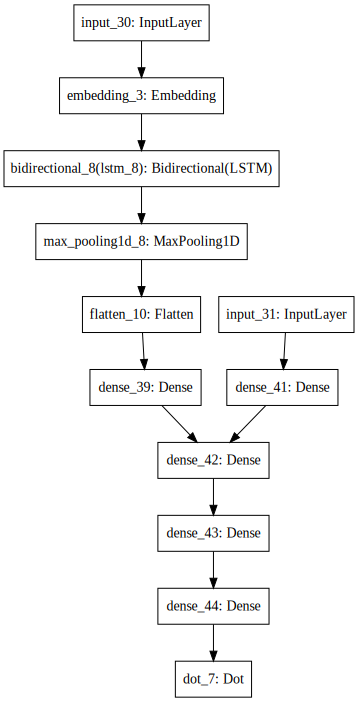

In [301]:
SVG(model_to_dot(qa_model).create(prog='dot', format='svg'))

### Build contrastive model
Two Siamese networks, trained jointly so as to minimize the hinge loss of their respective outputs.

In [302]:
# contrastive model
correct_answer = Input(shape=(EMBEDDING_SIZE,))
incorrect_answer = Input(shape=(EMBEDDING_SIZE,))
correct_cos_sim = qa_model([question, correct_answer])
incorrect_cos_sim = qa_model([question, incorrect_answer])

def max_margin_loss(cos_sims, margin=.2):
    correct, incorrect = cos_sims
    return K.relu(margin - correct + incorrect)

contrastive_loss = Lambda(max_margin_loss)([correct_cos_sim, incorrect_cos_sim])

# model
contrastive_model = Model([question, correct_answer, incorrect_answer], [contrastive_loss], name='contrastive_model')

### Build prediction model
This is what we'll use to compute the cosine similarity of novel `(question, answer)` pairs.

In [303]:
prediction_model = Model([question, answer], qa_model([question, answer]), name='prediction_model')

### Fit contrastive model
Fitting `contrastive_model` will implicitly fit `prediction_model` as well, so long as latter is compiled.

In [304]:
# compile
optimizer = Adam(.001, clipnorm=1.)

contrastive_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer=optimizer)
prediction_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer=optimizer)

# fit
contrastive_model.fit(
    x=[questions_train, correct_answers_train, incorrect_answers_train],
    y=y_train_dummy,
    batch_size=64,
    epochs=3,
    validation_data=([questions_val, correct_answers_val, incorrect_answers_val], y_val_dummy)
)

Train on 3988 samples, validate on 1012 samples
Epoch 1/3
3988/3988 [==============================] - 20s - loss: 0.1174 - val_loss: 0.0987
Epoch 2/3
3988/3988 [==============================] - 14s - loss: 0.0885 - val_loss: 0.0836
Epoch 3/3
3988/3988 [==============================] - 14s - loss: 0.0676 - val_loss: 0.0721


### Predict on new tweets

> "@united Flight is awful only one lavatory functioning, and people lining up, bumping, etc. because can't use 1st class bathroom. Ridiculous"

> "@usairways I've called for 3 days and can't get thru. is there some secret method i can use that doesn't result in you hanging up on me?"

> "@AmericanAir Let's all have a extraordinary week and make it a year to remember #GoingForGreat 2015 thanks so much American Airlines!!!"

In [305]:
new_questions = [
    "@united Flight is awful only one lavatory functioning, and people lining up, bumping, etc. because can't use 1st class bathroom. Ridiculous",
    "@usairways I've called for 3 days and can't get thru. is there some secret method i can use that doesn't result in you hanging up on me?",
    "@AmericanAir Let's all have a extraordinary week and make it a year to remember #GoingForGreat 2015 thanks so much American Airlines!!!"
]

new_questions_seq = tokenizer.texts_to_sequences(new_questions)
new_questions_seq = pad_sequences(new_questions_seq, maxlen=MAX_QUESTION_LEN)

In [306]:
n_questions, n_sentiments = len(new_questions_seq), len(sentiment_embeddings)
q = np.repeat(new_questions_seq, repeats=n_sentiments, axis=0)
a = np.tile(sentiment_embeddings, (n_questions, 1))

preds = prediction_model.predict([q, a])

### Tweet #1

In [307]:
positive_pred, neutral_pred, negative_pred = preds[:3]
print('Predictions:')
print(f'    🎉 (Positive): {positive_pred[0]:0.5}')
print(f'    😈 (Neutral) : {neutral_pred[0]:0.5}')
print(f'    😡 (Negative): {negative_pred[0]:0.5}')

Predictions:
    🎉 (Positive): 0.65457
    😈 (Neutral) : 0.71528
    😡 (Negative): 0.98755


### Tweet #2

In [308]:
positive_pred, neutral_pred, negative_pred = preds[3:6]
print('Predictions:')
print(f'    🎉 (Positive): {positive_pred[0]:0.5}')
print(f'    😈 (Neutral) : {neutral_pred[0]:0.5}')
print(f'    😡 (Negative): {negative_pred[0]:0.5}')

Predictions:
    🎉 (Positive): 0.53681
    😈 (Neutral) : 0.74388
    😡 (Negative): 0.98429


### Tweet #3

In [309]:
positive_pred, neutral_pred, negative_pred = preds[6:9]
print('Predictions:')
print(f'    🎉 (Positive): {positive_pred[0]:0.5}')
print(f'    😈 (Neutral) : {neutral_pred[0]:0.5}')
print(f'    😡 (Negative): {negative_pred[0]:0.5}')

Predictions:
    🎉 (Positive): 0.97144
    😈 (Neutral) : 0.64708
    😡 (Negative): 0.67285


### Additionally, we can predict on the full set of emojis
Some emoji embeddings contain `np.inf` values, unfortunately. We can likely mitigate this by further tweaking hyperparameters of our autoencoder.

In [310]:
all_embeddings = encoder.predict(emojis).astype(np.float64)
inf_mask = np.isinf(all_embeddings).any(axis=1)
print(f'{100 * inf_mask.mean():.3}% of values are `np.inf`.')

all_embeddings = all_embeddings[~inf_mask]

4.15% of values are `np.inf`.


In [311]:
n_questions, n_sentiments = len(new_questions_seq), len(all_embeddings)
q = np.repeat(new_questions_seq, repeats=n_sentiments, axis=0)
a = np.tile(all_embeddings, (n_questions, 1))

preds = prediction_model.predict([q, a])

In [318]:
def extract_top_5_argmax(preds, n=5):
    return np.argpartition(-preds.ravel(), 5)[:5]


def display_top_5_results(indices, emojis=emojis, inf_mask=inf_mask):
    n_rows = 1
    n_cols = 5
    
    assert n_rows * n_cols == len(indices)

    plt.figure(figsize=(3, 1))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=.1, hspace=.025)

    for gridspec_index, emoji_index in enumerate(indices):
        ax = plt.subplot(gs[gridspec_index])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        ax.imshow(emojis[~inf_mask][emoji_index], cmap='gray', interpolation='nearest')

### Tweet #1

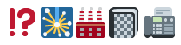

In [320]:
preds_1 = preds[:n_sentiments]
top_5_matches = extract_top_5_argmax(preds_1)
display_top_5_results(top_5_matches)

### Tweet #2

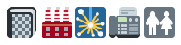

In [321]:
preds_2 = preds[n_sentiments:2*n_sentiments]
top_5_matches = extract_top_5_argmax(preds_2)
display_top_5_results(top_5_matches)

### Tweet #3

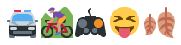

In [322]:
preds_3 = preds[2*n_sentiments:]
top_5_matches = extract_top_5_argmax(preds_3)
display_top_5_results(top_5_matches)

## Future work
In this work, we've trained a convolutional variational autoencoder to model the distribution of emojis. Next, we trained a Siamese question-answer model to answer text questions with emoji answers. Finally, we were able to use the latter to predict on novel emojis from the former.

Moving forward, I see a few logical next steps:

- Predict on emojis generated from the autoencoder.
- Add 1-D convolutions to the text side of the SQAM.
- Add an ["attention"](https://www.quora.com/What-is-attention-in-the-context-of-deep-learning) mechanism — the one component missing from the ["embed, encode, attend, predict"](https://explosion.ai/blog/deep-learning-formula-nlp) dynamic quartet of modern NLP.
- Improve the stability of our autoencoder so as to not produce embeddings containing `np.inf`.

Many thanks for reading, and emojis 🤘.

# References
- [Deep Language Modeling for Question Answering using Keras](http://ben.bolte.cc/blog/2016/language.html)
- [Applying Deep Learning To Answer Selection: A Study And An Open Task](https://arxiv.org/pdf/1508.01585v2.pdf)
- [LSTM Based Deep Learning Models For Non-Factoid Answer Selection](https://arxiv.org/pdf/1511.04108.pdf)
- [Embed, encode, attend, predict: The new deep learning formula for state-of-the-art NLP models](https://explosion.ai/blog/deep-learning-formula-nlp)
- [Keras Examples - Convolutional Variational Autoencoder](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py)